In [1]:
from pyspark.sql import SparkSession
app_name = "example_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

In [2]:
spark

In [3]:
sc

<SparkContext master=local[*] appName=example_notebook>

# Calculate Pi

## Common Boilerplate for RDD and DataFrame Methodology

In [41]:
import random
num_samples = 10000000

def inside(p):
    x, y = random.random(), random.random()
    return x*x + y*y < 1

def pi_calc(count_in, n):
    return 4 * float(count_in) / float(n)

## RDD (Old)

In [42]:
%%time
count = sc.parallelize(range(0, num_samples)).filter(inside).count()
print pi_calc(count, num_samples)

3.142534
CPU times: user 340 ms, sys: 50 ms, total: 390 ms
Wall time: 2.41 s


## DataFrame (New)

In [45]:
%%time
from pyspark.sql.types import BooleanType
from pyspark.sql.functions import udf
inside_udf = udf(inside, BooleanType())

data = spark.range(0, num_samples)
count = data.withColumn("inside", inside_udf("id")).where("inside = True").count()
# print data.take(1)
print pi_calc(count, num_samples)

3.1410752
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.37 s


# K Means

## Common Boilerplate for RDD and DataFrame Methodology

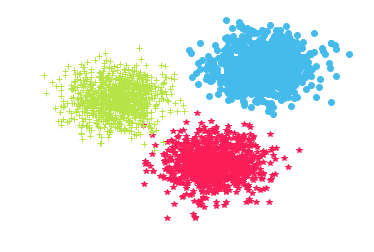

In [17]:
%matplotlib inline
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

size1 = size2 = size3 = 1000
samples1 = np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size1)
data = samples1
samples2 = np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size2)
data = np.append(data,samples2, axis=0)
samples3 = np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size3)
data = np.append(data,samples3, axis=0)
# Randomlize data
data = data[np.random.permutation(size1+size2+size3),]
np.savetxt('data.csv',data,delimiter = ',')



fig, ax = plt.subplots()

ax.plot(samples1[:, 0], samples1[:, 1],'*', color = '#fa1d57')
ax.plot(samples2[:, 0], samples2[:, 1],'o',color = '#45bbec')
ax.plot(samples3[:, 0], samples3[:, 1],'+',color = '#b7e549')
# fig.patch.set_visible(False)
ax.axis('off')
plt.show()

def nearest_centroid(line):
    x = np.array([float(line[0]),float(line[1])])
    closest_centroid_idx = np.sum((x - centroids)**2, axis=1).argmin()
    return (closest_centroid_idx,(x,1))

#plot centroids and data points for each iteration
def plot_iteration(means):
    fig, ax = plt.subplots()
    ax.plot(samples1[:, 0], samples1[:, 1], '.', color = '#45bbec')
    ax.plot(samples2[:, 0], samples2[:, 1], '.', color = '#45bbec')
    ax.plot(samples3[:, 0], samples3[:, 1],'.', color = '#45bbec')
    ax.plot(means[0][0], means[0][1],'*',markersize =10,color = '#fa1d57')
    ax.plot(means[1][0], means[1][1],'*',markersize =10,color = '#fa1d57')
    ax.plot(means[2][0], means[2][1],'*',markersize =10,color = '#fa1d57')
    ax.axis('off')
    plt.show()
    
K = 3

## RDD

[ 0.02926497  4.04246425]
[ 4.02074504  0.04352919]
[ 6.02833967  5.96051399]


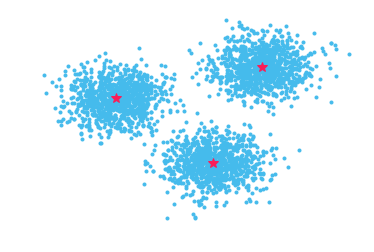

CPU times: user 80 ms, sys: 0 ns, total: 80 ms
Wall time: 799 ms


In [28]:
%%time
from pyspark.mllib.clustering import KMeans

# Load and parse the data
data = spark.read.format("csv").load("./data.csv").rdd
parsedData = data.map(lambda line: np.array([float(line[0]),float(line[1])]))

clusters = KMeans.train(parsedData, K, maxIterations=20, initializationMode="random")
for centroid in clusters.centers:
    print centroid

plot_iteration(clusters.centers)

## DataFrame

[ 4.02074505  0.04352919]
[ 0.02926497  4.04246425]
[ 6.02833967  5.96051399]


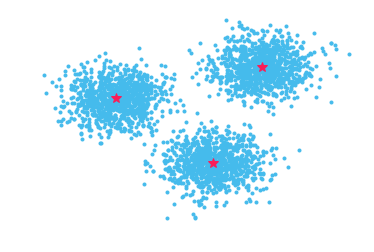

CPU times: user 100 ms, sys: 0 ns, total: 100 ms
Wall time: 765 ms


In [27]:
%%time
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import *

#load data and convert to dense vectors for use with 
data = spark.read.format("csv").load("./data.csv")

data = data.select(*(col(c).cast("float").alias(c) for c in data.columns))
assembler = VectorAssembler(
  inputCols=["_c0","_c1"], outputCol="features"
)
assembled = assembler.transform(data)

kmeans = KMeans(k=3, seed=1)
model = kmeans.fit(assembled.select("features"))

for centroid in model.clusterCenters():
    print centroid

plot_iteration(model.clusterCenters())

## Homegrown

Final Results:
[[ 4.01791049  0.044725  ]
 [ 6.02833967  5.96051399]
 [ 0.02810972  4.04526898]]


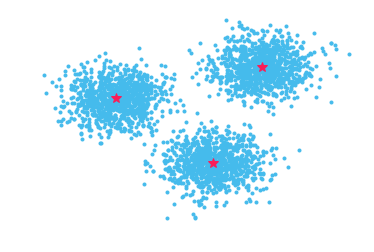

CPU times: user 260 ms, sys: 0 ns, total: 260 ms
Wall time: 1.74 s


In [34]:
%%time
# Initialization: initialization of parameter is fixed to show an example
centroids = np.array([[0.0,0.0],[2.0,2.0],[0.0,7.0]])

D = spark.read.format("csv").load("./data.csv").rdd.cache()

# sanity checks:
# print type(D)
# print D.map(nearest_centroid).take(1)


iter_num = 0
for i in range(10):  
    res = D.map(nearest_centroid).reduceByKey(lambda x,y : (x[0]+y[0],x[1]+y[1])).collect()
    '''
    res [
        (0, (array([  2.66546663e+00,   3.94844436e+03]), 1001)), 
        (2, (array([ 6023.84995923,  5975.48511018]), 1000)), 
        (1, (array([ 3986.85984761,    15.93153464]), 999))
        ]
    res[1][1][1] returns 1000 here
    '''
    
    res = sorted(res,key = lambda x : x[0])  # sort based on clusted ID
    centroids_new = np.array([x[1][0]/x[1][1] for x in res])  # divide by cluster size
    if np.sum(np.absolute(centroids_new-centroids))<0.01:
        break
#     print "Iteration" + str(iter_num)
    iter_num = iter_num + 1 
    centroids = centroids_new
#     print centroids
print "Final Results:"
print centroids
plot_iteration(centroids)